In [2]:
import functions as f
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import s3fs
import cftime
import intake
import numpy as np
from joblib import Parallel, delayed
from pyproj import Transformer
from datetime import datetime
from scipy import stats
from dask.diagnostics import ProgressBar
import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.widgets import Slider, Button 
from ipywidgets import interactive
import time
import os
%load_ext autoreload
%autoreload 2
%matplotlib inline
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

The Arctic has a greater temperature increase than other parts of the world because of arctic amplification [reference]. This has a direct influence on the sea ice extent, which has decayed rapidly in the last 30 years. This, in turn, inpacts the freshwater flux into the ocean sea surface, freshening the upper part of the water column and making it more stable, which may be linked to changes in the thermohaline circulation, and can therefore impact not only the circulation in the Arctic, but also around the whole globe. Manabe, S., S. R.: Simulation of abrupt climate change induced by freshwater input to the North Atlantic Ocean., Nature, 378, 165–167, 1995.

There exists numerous earth system models which include both the salinity at the ocean surface, as well as the vertical structure of the ocean. However, such models often parameterize the salinity in the ocean. Therefore, good in situ measurements are needed to tune the parametrizations of the models to reflect the real world better. This, in turn, is problematic, as in situ measurements of the ocean are very scarce due to the difficult ocean conditions, making research voyages expensive. https://essd.copernicus.org/articles/14/307/2022/#bib1.bibx20. There are especially few ocean measurements in the polar regions, as these regions exhibit even harder conditions than the rest of the world oceans, due to among other things rough currents, sea ice and cold temperatures. 

Good numerical models are therefore crucial for understanding ocean processes the world oceans, especially in the polar regions. This study will focus on the ocean salinity in the Arctic, and will compare observational data on the sea surface salinity from the BEC Arctic+ satellite product and salinity data from ARGO floats in the Arctic to two earth system models, the UKESM and ..... to see how well these two models perform at parametrizing the ocean salinity. 

This paper will focus on sea ice as a main contributor to the freshwater fluxes in and out of the ocean, however, we keep in mind that other factors, such as precipitation and river runoffs are important sources of freshwater in the ocean as well. 

# Sea Ice Effect on Sea Surface Salinity

Formation and decay of sea ice is a major driving factor for the sea surface salinity. Formation of sea ice requires the freezing of salty ocean water, however, the salt crystals will not be freezed with the water, but rather separated from the water during this process. The salt crystals will then try to mix with the remaining, unfreezed water, in turn making it even saltier, and lowering the temperature required for it to freeze. This very salty water is called brine, and can either be trapped in the sea ice, creating pockets in the sea ice with salty cold water which does not freeze because of the salt level, or it can escape from the ice and flow out into the ocean surface. Due to the high concentration of salt in the brine, it is heavier than regular ocean water at the surface, and will start sinking, disrupting the stability and stratification of the upper water column, leading to convective mixing. 

Decay of sea ice releases freshwater into the ocean. Freshwater is lighter than the salty ocean water, and will stay on top of the water column. This in turn stabilizes the water column, and prevents vertical mixing. Decay of sea ice is most prevelant during the melting season, but freshwater input into the ocean can come from other sources, such as river runoffs and precipitation, which stabilizes the water column.

Another way sea ice can affect the ocean is by covering it up, blocking out both sunlight and atmospheric forcing. This is not directly related to the salinity in the ocean, but is still important for the vertical circulation. This controlls the windstress input into the ocean, as well as heat input. Additionally, when sea ice floats in a different direction of the ocean currents, for example due to the wind stress in the atmospheric boundary layer, which in turn will stirr the water column. 

In terms of sea ice, this paper will mostly focus on the freshwater input into the ocean as a result of sea ice decay.



# Data

## Satellite Observations of Salinity at the Sea Surface
The sea surface salinity (SSS) satellite observations are produced by Barcelona Expert Center (BEC) as a part of the Arctic+ salinity project. Measuring SSS using satellites has proved to be challenging, as the sensitivity of the brightness temperature to SSS is low, and the changes is SSS in the open ocean are small if river discharge is not considered. This means that the satellite accuracy has to be high to capture the regional changes in SSS. The Arctic+ project was launched as an initiative by the European Space Agency (ESA) to improve the existing Soil Moisture and Ocean Salinity (SMOS) satellite data. The methodology for how this has been improved is explained in https://essd.copernicus.org/articles/14/307/2022/, and the product is an improved SSS observational system with a higher spatial resolution. 

The dataset contains a 9-day Arctic SSS product from satellite observations, placed in an EASE-Grid 2.0 North. It covers the whole Arctic region, from -180 to 180 longitude and 50 to 90 latitude, while the geospatial resolution is 25km. The dataset also contains data from January 2011 to December 2019. Arctic+Salinity_D1.1_RDB_v1r9; Arctic+Salinity_D1.2_DUM_v2r7; Arctic+Salinity_D1.3_ATBD_v2r0; http://bec.icm.csic.es The dataset is freely accessible on https://bec.icm.csic.es/.

## Satellite Observations of Sea Ice Extent



## CTD Measurements of Ocean Vertical Structure
The CTD measurements are provided by the ARGO program, which is an international program which aims to constantly measure the properties of ocean water, such as salinity and temperature, across the globe. To do this, the ARGO program has placed out around ~3800 automatic floats in the ocean (number of floats is increasing each year), which sink down to some ocean depth before floating up again, all while measuring different ocean paramters. After emerging, these floats send their data to some database and sink down again, which happens on average on a 10 day cycle. https://www.seanoe.org/data/00311/42182/

Unfortunately, ARGO floats are not so common in the Arctic, as the harsh environment and sea ice prevents ruins the floats more often than not. There are for instance no ARGO floats in the Laptev Sea, which is one of the study regions in this paper, due to the region being completely covered by sea ice during large periods of the year. However, there are still some floats in the Greenland Sea region which will be used in this paper to study the vertical structure of the ocean at these location, which will also be used as a validation for the vertical structure of earth system models. The measurement data can be accessed from https://argo.ucsd.edu/data/.


## Earth System Models
The models which will be considered in this paper are the UKESM (UKE Earth System Modelling Project), and the CNRM (Centre National de Recherches Meteorologiques), and both models are part of the CMIP6 project (Coupled Model Intercomparison Project), hosted by WCRP (The World Climate Research Programme). Both models are coupled ocean and atmosphere models.  

CNRM has a spatial ocean resolution of 100km, and the historical experiment, which is the one that will be used, gives monthly data from 1850 to 2014. 

https://www.cen.uni-hamburg.de/en/icdc/data/cryosphere/cmip6-sea-ice-area/cnrm-esm2.html



# Methods

## Seasonality of Sea Surface Salinity
Because the sea ice extent (SIE) varies changes depending on the season, the SSS should in theory somewhat follow the sea ice variation, meaning that we should have a decrease in SSS during warmer seasons, when sea ice melts resulting in a freshwater input into the ocean, and vice versa. The seasonality of the SSS can be investigated by calculating the average SSS value of the specified region for each day. Then, one can group the averages by the day of the year, i.e. group all January 3rd for all years, group all february 23rd for all years, and so on, and find the average SSS value for the that specific day in any given year. 

By creating so called seasonality graphs, one can study how the SSS is expected to vary over the course of a year. This, in turn, makes it comparable to the seasonal SIE, to see if they are correlated or not. It is expected that sea ice and SSS will have a large correlation, however, there is also the possibility of other factors being at play. 

## Model Comparison
The UKESM and CNRM both respectively include 16 and 11 model members which contain the ocean salinity variable. Each member calculates their respected variable value based on the implemented parametrization for that variable in their model, however, the way the members differ is in their initial conditions. Therefore, the members will yield somewhat different results. An idea would be to just pick out a member from both models at random, however, this approach might prove to be problematic, as the randomly selected member might have initial conditions which are not realistic. Instead, we will bring in all members in UKESM and CNRM which contain the ocean salinity variable, and avarage over them. 

# Study area

In [2]:
path='escience2022/Antoine/ESA_SMOS_Arctic_Sea_Surface_Salinity/'
years = [2011,2012,2013,2014,2015,2016,2017,2018,2019]
sat_data = f.collect_satellite_data(years, path)

In [38]:
f.interactive_plot_whole_region(sat_data, title='Sea Surface Salinity Around The Polar Region')

NameError: name 'sat_data' is not defined

*Figure 1: Sea surface salinity observational data from BEC Arctic+ product for the whole Arctic region for 2011-09-09. Major rivers are also included in the figure. The figure includes an interactive slider which allows for day change, so that one can inspect the SSS at different days in 2011 (Jupyter Notebook only).*

In [3]:
SatRegion1 = f.slice_data(sat_data, '2009-01-01', '2022-02-01', -10, 10, 70, 85)
SatRegion2 = f.slice_data(sat_data, '2009-01-01', '2022-02-01', 100, 160, 70, 80)

In [5]:
f.interactive_plot(SatRegion1, SatRegion2)

interactive(children=(Dropdown(description='time', index=250, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1…

*Figure 2: Sea surface salinity observational data from BEC Arctic+ product for two defined regions at 2011-09-09, Greenland Sea (left) (-10 to 10 lon, 70 to 85 lat) and Laptev Sea (right) (100 to 160 lon, 70 to 80 lat). Rivers are included in the figure. An interactive slider allows to change the day in 2011 shown in the figure (Jupyter Notebook only).* 

Figure 1 shows the whole extent of the SSS from satellite observations during 2011-09-09. We imidietely notice that there is some missing data around the north pole, which is a direct result of the sea ice, which blocks the SSS satellite measurements of the ocean surface below the sea ice. However, the SIE is changing over the season due to ice melting during warmer seasons and water freezing during colder seasons, with SIE at a minimum sometime during the month of September. Figure 1 includes an interactive slider (available in Jupyter Notebook version), where one can select the day of the year in 2011 to see which regions have observations for that day. By using this slider and checking different days, we clearly see that the SIE changes over time. The changing SIE will directly result in more observational satellite data of SSS during warmer months and less during colder months. Additionally, we also see that the satellite filters out observations around the coasts. 

Figure 2 shows the two regions of focus for this paper during 2011-09-09. On the left we see an area in the Greenland Sea region, which I defined to be between -10 and 10 degrees longitude and 70 to 85 degrees latitude. On the right, we have the Laptev Sea, defined to be from 100 to 160 degrees longitude and 70 to 80 degrees latitude. As for figure 1, figure 2 includes an interactive slider available when viewing this paper in Jupyter Notebook. These two regions were selected because of large differences in their characteristics. 
* The Greenland Sea region has an average depth of ~1444m, where it goes down to around ~3000m in some areas https://www.worldatlas.com/seas/greenland-sea.html, whille the Laptev Sea region is placed within a continental shelf. This results in the region having a rather deep maximum depth, at around ~3385m, but around 50% of the sea is less than 50m deep, giving the region a steep topography. The average depth in this Laptev Sea region is around ~578m https://www.worldatlas.com/seas/laptev-sea.html
* The Greenland Sea region is in open sea, meaning that it is not surrounded by land and while the SIE will cover up some parts of it during winter, large parts will still be open during ice extent maximum. In contrast, the Laptev Sea region is surrounded by land, and is almost completely covered by sea ice during the winter season. Due to this, there are few satellite observations during the winter seasons.
* Because the Laptev Sea is surrounded by land, there is also the possibility of the existance of rivers which run out into this region, which is a large source of freshwater input. Rivers are shown in figure 2, and we see that there are no rivers running out into the Greenland Sea.

As SSS is influenced by freshwater input, rivers, precipitation and sea ice melt play a great role in the changes in salinity. For this reason, the figures 1 and 2 include some of the major rivers in the area. As we clearly see, there are no rivers running off into the Greenland Sea region. This means that changes in salinity are mostly due to interaction with sea ice and precipitation in the Greenland Sea region, whereas rivers are included in the Laptev Sea region. From the right panel in figure 2 we see a larger salinity gradient in the region than in the Greenland Sea, with lower salinity in the sea surface closer to the coast where we have river runoff. 



# Results and discussion

## Seasonality

In [4]:
MeanSat = SatRegion1['sss'].groupby('time.dayofyear').mean(dim=['time', 'x', 'y']).compute()#.mean('x').mean('y').compute()
s = SatRegion1['sss'].mean(dim=['x','y']).compute().groupby('time.dayofyear')
StdSat = SatRegion1['sss'].groupby('time.dayofyear').std(dim=['time', 'x', 'y']).compute()

MeanSat2 = SatRegion2['sss'].groupby('time.dayofyear').mean(['time', 'x', 'y']).compute()
s2 = SatRegion2['sss'].mean(dim=['x', 'y']).compute().groupby('time.dayofyear')
StdSat2 = SatRegion2['sss'].groupby('time.dayofyear').std(dim=['time', 'x', 'y']).compute()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


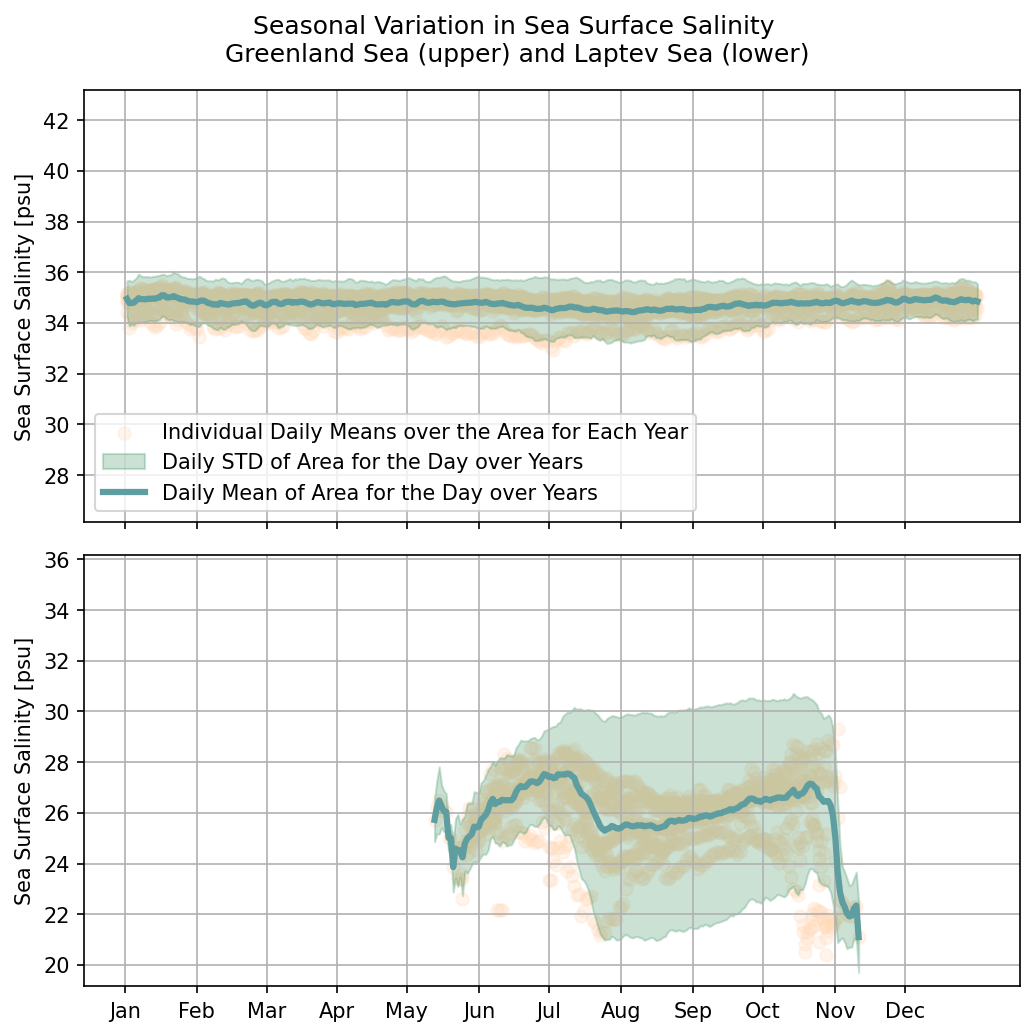

In [7]:
x = np.arange(1,367)

dic = { 0:'Jan', 31:'Feb', 61:'Mar', 91:'Apr', 121:'May', 152:'Jun', 182:'Jul', 213:'Aug', 244:'Sep', 274:'Oct', 305:'Nov', 335:'Dec'}
ticks = [0,31,61,91,121,152,182,213,244,274,305,335]
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]

fig, ax = plt.subplots(2,figsize=(7,7), dpi=150, sharex=True)
for month in s.groups.keys():
    m = np.full(len(s[month]), month)
    sct = ax[0].scatter(m, s[month], color='peachpuff', alpha=0.25)


for month in s2.groups.keys():
    m = np.full(len(s2[month]), month)
    sct2 = ax[1].scatter(m, s2[month], color='peachpuff', alpha=0.25)

ax[0].fill_between(x, MeanSat-StdSat, MeanSat+StdSat, color='seagreen', alpha=0.25, label='Daily STD of Area for the Day over Years')
ax[1].fill_between(x, MeanSat2-StdSat2, MeanSat2+StdSat2, color='seagreen', alpha=0.25)
sct.set_label('Individual Daily Means over the Area for Each Year')

ax[0].plot(x, MeanSat, color='cadetblue', lw = 3, label='Daily Mean of Area for the Day over Years')
ax[1].plot(x, MeanSat2, color='cadetblue', lw = 3)

ax[0].set_xticks(ticks)
ax[0].set_xticklabels(labels)
#ax[1].title('Timeseries of Sea Surface Salinity \nSiberian Sea')
ax[0].set_ylabel('Sea Surface Salinity [psu]')
#ax[0].title('Seasonal Variability of Sea Surface Salinity \n Greenland Sea')
ax[1].set_ylabel('Sea Surface Salinity [psu]')
ax[0].legend(loc='lower left')
#ax.twinx()
plt.tight_layout()
ymin, ymax = ax[0].get_ylim()
ymin2, ymax2 = ax[1].get_ylim()
ax[0].set_ylim([ymin2+7, ymax+7])
ax[1].set_ylim([ymin2, ymax])
ax[0].grid()
ax[1].grid()
fig.suptitle('Seasonal Variation in Sea Surface Salinity \nGreenland Sea (upper) and Laptev Sea (lower)')
plt.tight_layout()
plt.show()

*Figure 3: The seasonality of the sea surface salinity in the Greenland Sea (upper) and Laptev Sea (lower) calculated by taking daily mean for each year over the whole satellite dataset, 2009-01 to 2019-12. The Turqoise line shows the average salinity value at the surface for the region, with the green filled out area around the line around the mean being the standard deviation. The orange dots are the daily mean of the region for each specific day*

Figure 3 shows the seasonal variation in SSS from the satellite observations for the two selected region, Greenland Sea (upper) and Laptev Sea (lower). The orange dots in the figure represent the daily average of the region for each specifc day in each specific year, whereas the thich turqoise line represents the average SSS value for the region over multiple years. Figure 3 also includes the standard deviation from the mean, represented with a green area around the average (turqoise line), to show the spread in the average values.

By first looking at the seasonality of the Greenland Sea in the upper panel of figure 3, we see that there is a small decrease in the average SSS starting from around the middle of June, where the SSS drops from approximately ~35 psu in the beginning of June to approximately ~34.5 psu in August. This decrease is rather small, and seems almost constant compared to the changes in the average SSS for the Laptev Sea, so this will be enlarged in the next section where we compare SIE to the SSS. However, this small decrease in SSS during the warmer months implies that the freshwater input into the ocean as a result of melting sea ice is in fact contributing to the decrease in SSS.

Now looking at the seasonality of SSS for the Laptev Sea in the lower panel of figure 3, the first thing we notice is that there is no data between the middle of November and the middle of June. This is a direct result of the region being covered by sea ice during this period, as can be seen if one would change the day in the interactive figure 2. As a matter of fact, in the beginning of June, the Laptev Sea region is still not really opened up, and the average might be heavily influenced by which part of the region opens up first. As we see in figure 2, there is a large SSS gradient between the coastal waters and the ocean some distance away from the coast. This means that if the coastal waters thaws first, the average SSS lean towards lower values, while if the waters some distance away from the coast thaws first, the average SSS will lean towards larger values. The same applies for the when the ocean freezes during the colder months. To counteract this, the beginning and the end of the period should not be considered. 

By looking through the different days in figure 2, we see that it is in fact the more open and saltier waters which thaw first in the Laptev Sea, and that the sweeter coastal waters thaw somewhere in the middle of July. This is reflected in the lower panel in figure 3, where we see that the average SSS for the region drops quickly during June. To emphesize, this does not necessarily mean that we have a sudden large freshwater input, but rather, that the sweeter region thaws and is then included when the average is calculated. 

Figure 2 also indicates that the fresher water in the Laptev Sea freezes first. This can be because the coastal waters are colder due to different factors, for example cold temperature flux from the land or warm temperature to the open waters due to some underlying ocean current. However, another explanation for this is that fresher waters freeze at a higher temperature than saline waters. This happens because salt molecules blocks the water molecules from grouping together, which in turn prevents the water from freezing. So water freezes at a lower temperature as the salinity increases *reference the book*. By assuming that the temperature is homogeneous over the whole region, which is not a fair assumption and should really be investigated, we can assume that the fresher water thaws later and freezes earlier than saline water simply because the temperature required for thawing and freezing fresher water is closer to 0 degrees Celcius compared to saline water. Note however, that when we are talking about fresher or sweeter waters, we are still talking about saline waters, just less saline waters in comparison to other regions. 

Going back to figure 3, another interesting part of the figure is that the standard deviation of the SSS is much larger for the Laptev Sea than for the Greenland Sea. This reflects the fact that there is a large variance in the SSS in the Laptev Sea, both spatially, as we have discussed, and temporally. The temporal variance is reflected by the large spread of the individual average SSS values, represented by the orange dots in the figure, where we see that the average SSS value for a given day of the month tend to differ by a large amount from the same days in different years. Figure 4 below shows a histogram of the distribution SSS distribution for the two regions. 

In [5]:
MeanSat.to_netcdf('SSSGL.nc')
MeanSat2.to_netcdf('SSSLS.nc')

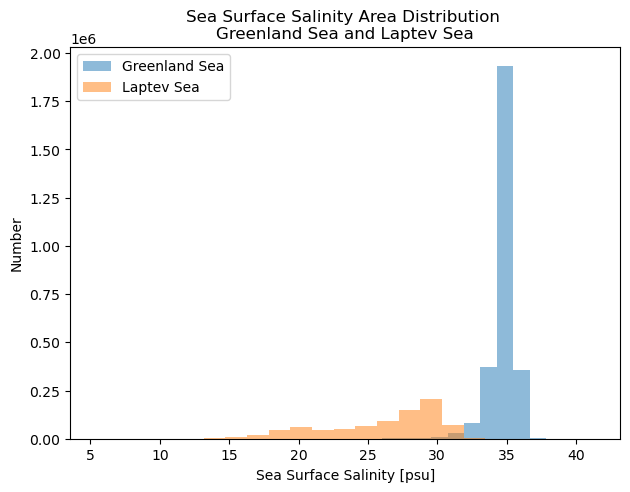

In [10]:
plt.hist(SatRegion1['sss'].values.ravel(), bins=20, alpha=0.5, label='Greenland Sea')
plt.hist(SatRegion2['sss'].values.ravel(), bins=20, alpha=0.5, label='Laptev Sea')
plt.xlabel('Sea Surface Salinity [psu]')
plt.ylabel('Number')
plt.legend(loc='upper left')
plt.tight_layout()
plt.title('Sea Surface Salinity Area Distribution \nGreenland Sea and Laptev Sea')
plt.show()

*Figure 4: Histogram of the sea surface salinity distribution over the whole satellite data period 2009-01 to 2019-12 over the Greenland Sea (blue) and Laptev Sea (orange).* 

Figure 4 shows the SSS distribution over the whole satellite data period over the Greenland Sea (blue) and Laptev Sea (orange). From the figure we see that the spread in SSS values is definitely larger for the Laptev Sea, which explains the standard deviation from figure 3. The Greenland Sea has most of its SSS values at around 35 psu, with some values deviation a little bit, and some extreme values going down to around 30 psu. Looking at figure 2 again, we see that this seems reasonable, as figure 2 shows a rather (but not perfectly) homogeneous salinity distribution over the Greenland Sea region.  

If one looks closely at the orange section of the histogram, the part representing the spread in the Laptev Sea, one can notice that there are two peaks in the distribution, one at around ~28-30 psu and one at around ~20 psu. This is again most likely due to the large salinity gradient already discussed previously. Nevertheless, figure 4 shows the reason behind the large standard deviation for the Laptev Sea compared to the Greenland Sea. 

## Sea Surface Salinity Dependance on Sea Ice Concentration

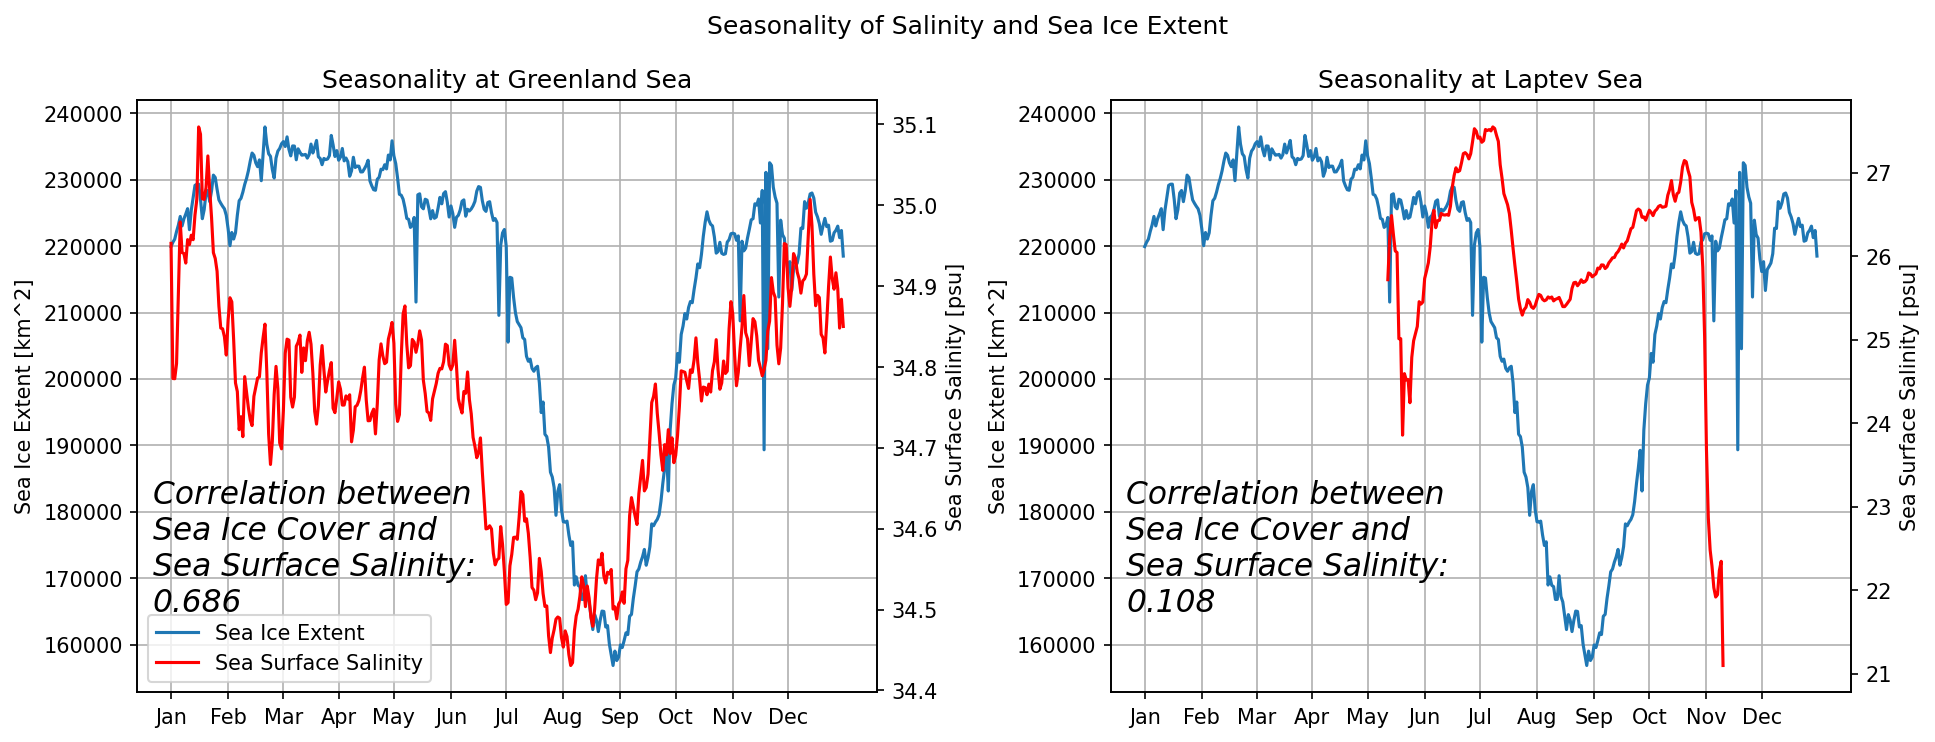

In [54]:
ice_path = 'AMSR2_E_Daily sea ice extent_GL sea.nc'
ice_path2 = 'DailySeaiceextentSiberianSea.nc'
ice_ds = xr.open_dataset(ice_path)
ice_ds2 = xr.open_dataset(ice_path2)

MeanIceDaily = ice_ds['z'].groupby('time.dayofyear').mean('time').compute()
STDIceDaily = ice_ds['z'].groupby('time.dayofyear').std('time').compute()

MeanIceDaily2 = ice_ds['z'].groupby('time.dayofyear').mean('time').compute()
STDIceDaily2 = ice_ds['z'].groupby('time.dayofyear').std('time').compute()

x = np.arange(366)
fig, ax = plt.subplots(1,2, figsize=(13,5), dpi=150)

ax1 = ax[0].twinx()
ax2 = ax[1].twinx()

ln = ax[0].plot(x, MeanIceDaily, label='Sea Ice Extent')
ln2 = ax1.plot(x, MeanSat, 'r', label='Sea Surface Salinity')
ax[0].legend()

ax[1].plot(x, MeanIceDaily2)
ax2.plot(x, MeanSat2, 'r')

dic = { 0:'Jan', 31:'Feb', 61:'Mar', 91:'Apr', 121:'May', 152:'Jun', 182:'Jul', 213:'Aug', 244:'Sep', 274:'Oct', 305:'Nov', 335:'Dec'}
ticks = [0,31,61,91,121,152,182,213,244,274,305,335]
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]

nans = np.where(np.isnan(MeanSat2)) #Gives a list of indexes, from this list I can see that MeanSat2 is not nan between index 131 and 315
corr = [np.corrcoef(MeanIceDaily, MeanSat)[0,1], np.corrcoef(MeanIceDaily2[132:314], MeanSat2[132:314])[0,1]]

for i in range(2):
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(labels)
    ax[i].grid()
    ax[i].text(-10, 165000, f'Correlation between \nSea Ice Cover and \nSea Surface Salinity:\n{corr[i]:.3f}', style ='italic',
        fontsize = 15, color ="black")
    ax[i].set_ylabel('Sea Ice Extent [km^2]')
ax1.set_ylabel('Sea Surface Salinity [psu]')
ax2.set_ylabel('Sea Surface Salinity [psu]')

lns = ln + ln2
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0)

fig.suptitle('Seasonality of Salinity and Sea Ice Extent')
ax[0].set_title('Seasonality at Greenland Sea')
ax[1].set_title('Seasonality at Laptev Sea')

plt.tight_layout()
plt.show()

#SeaIceCover
#When Sea Ice melts, it will become thinner in the beginning, but will still cover the ocean
#this means that while the sea ice extent does not get much smaller, it becomes thinner, so we have a freshwater input into the ocean, meaning that salinity should decrease

*Figure 5: Seasonality of sea ice extent (blue) and sea surface salinity (red) at Greenland Sea (left) and Laptev Sea (right).*

Figure 5 shows the seasonality of SSS (red graph) compared to the seasonality of sea SIE (blue graph) at the two regions. The seasonality of SSS is exactly the same as in figure 3, but this time the we have enlarged the two figures so that one can see the fluctuations at both locations better (note that the SSS y-axis in the two panels in figure 5 differ). This allows us to see the seasonality of SSS at the Greenland Sea region better, and here we clearly see that the SSS value drops from around ~35 psu in June to around 34.5 psu in August (this was not as apparent in figure 3). 

NOTE::: I THINK BOTH THE SEA ICE EXTENTS ARE FOR THE GREENLAND SEA, FIX FOR LATER

First, taking a look at the left panel in figure 5, we see that SSS and SIE are well correlated, especially after the month of May, where we see that both SSS and SIE decreases and increases approximately at the same time. However, there is also a shift in the minimum peak of the two variables, where the minimum SSS happens about a month earlier than minimum SIE. This is not so strange when one considers that the SIE in the figure is only how far the sea ice actually extends, not how thick it is. This means that the thickness of the sea ice can decay, giving a freshwater input into the ocean, thus lowering SSS, whereas the extent of the sea ice does not change. When the ocean water freezes into sea ice again, sometime in September, we know that the salt crystals will not be freezed with the ocean water, but rather, be released into the ocean surface, which is why we notice an increase in SSS with an increase in SIE. 

The left panel in figure 5 also shows that SSS decreases during the months of February to May, while the SIE increases in the same time period. This might be due to the average acting strangely because of the missing data due to the sea ice, as talked about previously, however, it can also be due to freshwater input from other sources. For example, there might be more precipitation during this time period, or some other driving factors which should be studied more. 

For the correlation between SSS and SIE in the right panel of figure 5, one should really only consider the months between July and November, for the same reasons as stated previously. By only looking at these months, we see that SSS decreases during July, as does the SIE, and has a minimum during August, while the SIE still has a minimum during September, and both increase after that. By looking at the axis of the figures, we see that the SSS varies much more during this season at the Laptev Sea region than at the Greenland Sea region. We can assume that this is because the Laptev Sea has an additional freshwater input, other than sea ice decay, which is river runoff, and maybe the seasonality of river runoff should also be added to the figures to investigate its effect.

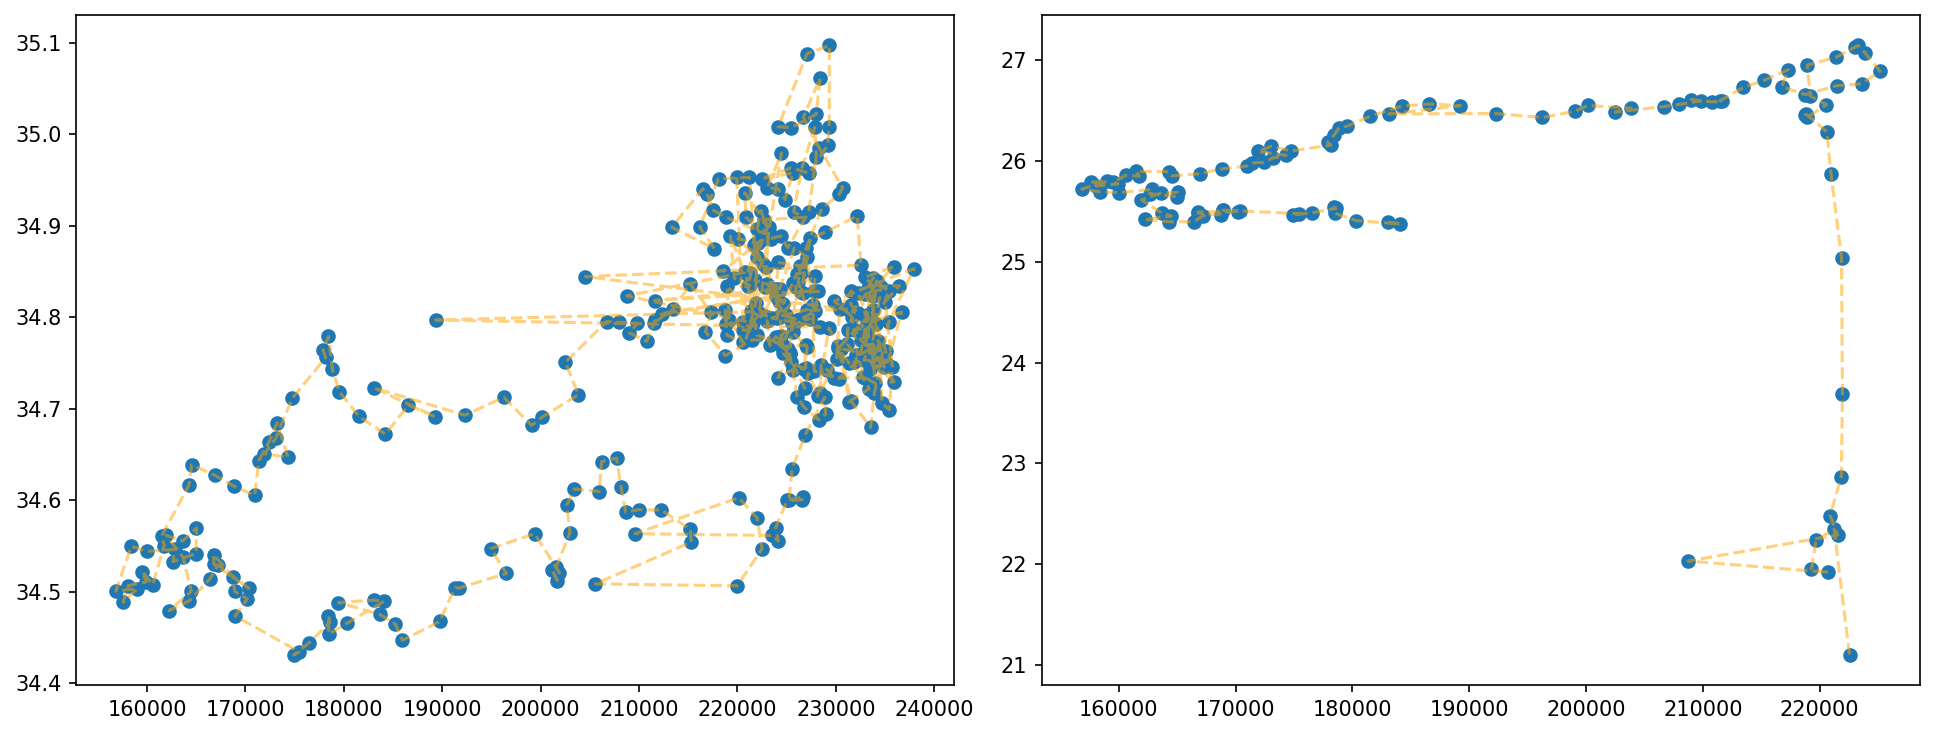

In [63]:
fig, ax = plt.subplots(1,2, figsize=(13,5), dpi=150)
ax[0].scatter(MeanIceDaily, MeanSat)
ax[1].scatter(MeanIceDaily2[7*30:11*30], MeanSat2[7*30:11*30])
ax[0].plot(MeanIceDaily, MeanSat, '--', color='orange', alpha=0.5)
ax[1].plot(MeanIceDaily2[7*30:11*30], MeanSat2[7*30:11*30], '--', color='orange', alpha=0.5)
plt.tight_layout()

#Circular means lag in the signal, one that increases and then second one increases

*Figure 6: A figure showing the correlation between sea ice extent and sea surface salinity for satellite data by plotting them against one another. Greenland Sea on the left and Laptev Sea on the right.*

Figure 6 shows the correlation between the SIE and SSS for the Greenland Sea (left) and Laptev Sea (right). As can be noticed from the left panel, we have a correlation between the SIE and SSS, where both values get decrease and increase at the same time, as was apparent in figure 5 awsell. The correlation in the left panel of figure 6 also shows that the result of plotting these two against each other is circular (if one puts their willingness into it), which is what happens when the decrease and increase in the two values is shifted compared to one another.  

The right panel of figure 6 however, does not show any implications of there being a correlation. Here, only the data between June and November have been included for the Laptev Sea, because of the beforementioned reasons. We see that whenever SIE increases, it does not necessarely mean that SSS increases as well. So again, there must be some other factors here aswell, or just an error in the calculation of the average values for the region, as it is covered by ice for long periods of the year. 

# Timeseries of Greenland Sea

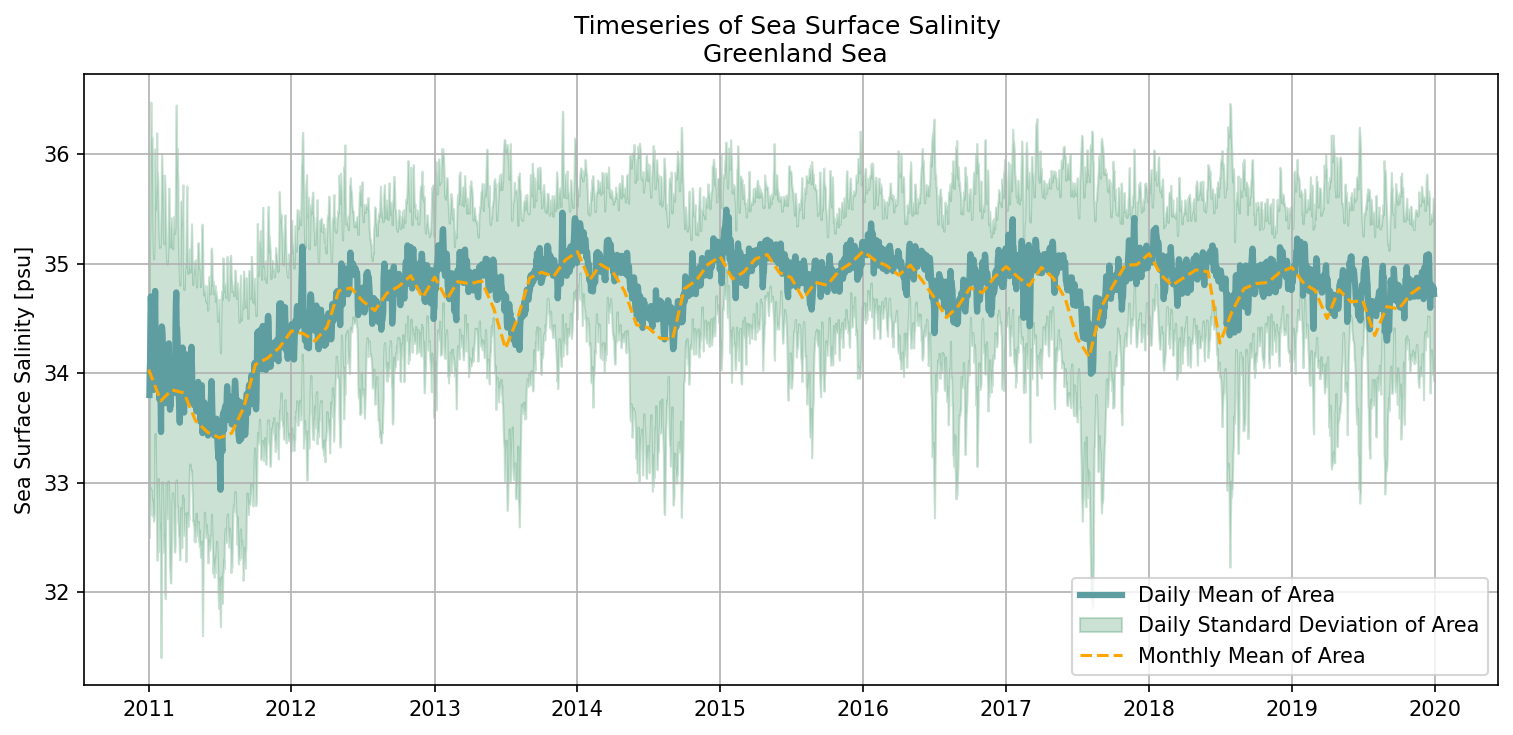

In [24]:
#Move this to the bottom, final figure alongside timeseries of the two models.

month = SatRegion1['time.month']
year = SatRegion1['time.year']
mean_list = []
years = [2011,2012,2013,2014,2015,2016,2017,2018,2019]
for y in years: #This piece of the code is definitely not my biggest pride....
    for m in [1,2,3,4,5,6,7,8,9,10,11,12]:
        tmp = SatRegion1.where((month.isin(m)) & (year.isin(y))).mean('time')
        mean_list.append(tmp['sss'].mean())
TimeSeriesStd = SatRegion1['sss'].std(dim=['x', 'y']).compute()
TimeSeriesMean = SatRegion1['sss'].mean(dim=['x', 'y']).compute()

dates = np.array([datetime.datetime(y,1,1) + relativedelta(months=m)for y in years for m in range(12)])
fig, ax = plt.subplots(figsize=(10,5), dpi=150)
plt.plot(TimeSeriesMean.time, TimeSeriesMean, color='cadetblue', lw = 3, label='Daily Mean of Area')
ax.fill_between(TimeSeriesMean.time, TimeSeriesMean-TimeSeriesStd, TimeSeriesMean+TimeSeriesStd, color='seagreen', alpha=0.25, label='Daily Standard Deviation of Area')
plt.plot(dates, mean_list, '--', color='orange', label='Monthly Mean of Area')
plt.grid()
plt.title('Timeseries of Sea Surface Salinity \n Greenland Sea')
plt.tight_layout()
plt.ylabel('Sea Surface Salinity [psu]')
plt.legend(loc='lower right')
plt.show()

# ARGO data

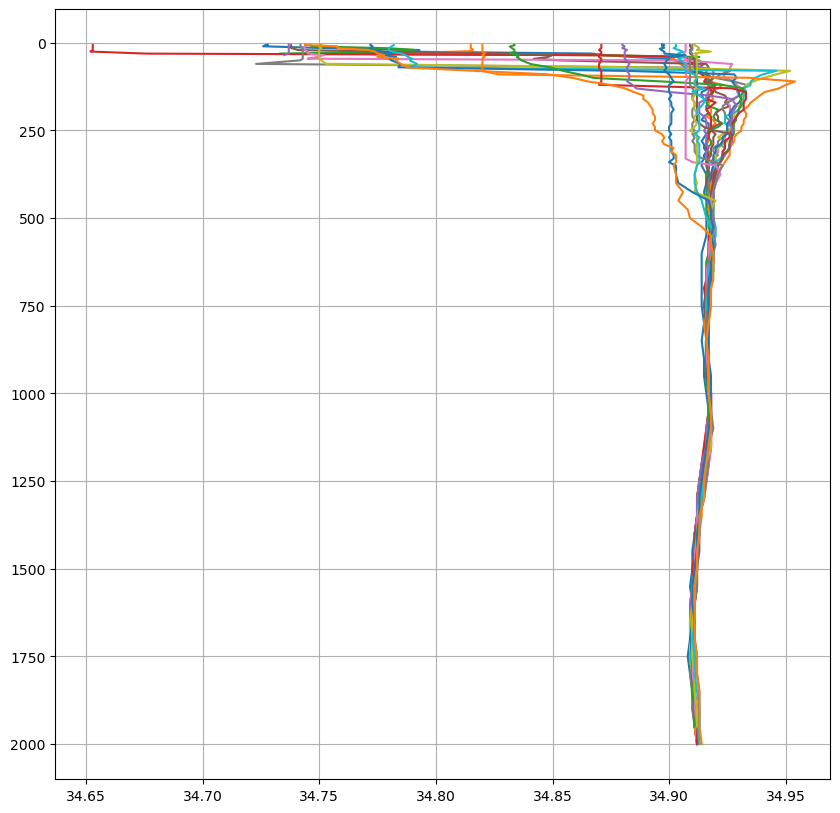

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(30):
    plt.plot(Argo1['PSAL_ADJUSTED'][i], Argo1['PRES'][i])
    #plt.plot(Argo2['PSAL_ADJUSTED'][i], Argo2['PRES'][i])
plt.gca().invert_yaxis()
ax.grid()

# Validation of Model Data at the Surface

In [62]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(variable_id='so', source_id='UKESM1-0-LL', activity_id='CMIP', experiment_id='historical')
cat2 = col.search(variable_id='areacello', source_id='UKESM1-0-LL')
cat3 = col.search(source_id=['CNRM-ESM2-1'], 
                 experiment_id=['historical'], 
                 variable_id='so') 
cat4 = col.search(source_id=['CNRM-ESM2-1'], variable_id='areacello', activity_id='CMIP', experiment_id='historical', member_id='r1i1p1f2')

In [63]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dset_dict2 = cat2.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dset_dict3 = cat3.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dset_dict4 = cat4.to_dataset_dict(zarr_kwargs={'use_cftime':True})
MDS_all = dset_dict[list(dset_dict.keys())[1]]
MDS2_all = dset_dict3[list(dset_dict3.keys())[0]]
ModelDataList2 = list(dset_dict2.keys())
ModelDataList4 = list(dset_dict4.keys())
MDS = MDS_all.isel(lev=0).so.mean('member_id', keep_attrs=True)
MDS2 = MDS2_all.isel(lev=0).so.mean('member_id', keep_attrs=True)
areacello = dset_dict2[ModelDataList2[0]].squeeze()
areacello2 = dset_dict4[ModelDataList4[0]].squeeze()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [67]:
MReg = MDS.sel(time = slice('1850','2010'))
MReg = f.slice_data(MReg, min_lat = 70, max_lat = 85, min_lon = -10, max_lon = 10)
MReg2 = MDS.sel(time = slice('1850','2010'))
MReg2 = f.slice_data(MReg2, min_lat = 70, max_lat = 80, min_lon = 100, max_lon = 160)


MReg3 = MDS2.sel(time = slice('1850', '2010'))
MReg3 = MReg3.where(
            (MReg3['lon'] > -10)
            & (MReg3['lon'] < 10)
            & (MReg3['lat'] > 70)
            & (MReg3['lat'] < 85),
            drop=True)
MReg4 = MDS2.sel(time = slice('1850', '2010'))
MReg4 = MReg4.where(
            (MReg4['lon'] > 100)
            & (MReg4['lon'] < 160)
            & (MReg4['lat'] > 70)
            & (MReg4['lat'] < 80),
            drop=True)

In [69]:
ac=areacello.where(
    (areacello['longitude'] > -10)
    & (areacello['longitude'] < 10)
    & (areacello['latitude'] > 70)
    & (areacello['latitude'] < 85),
    drop=True
    )
ac2=areacello.where(
    (areacello['longitude'] > 100)
    & (areacello['longitude'] < 160)
    & (areacello['latitude'] > 70)
    & (areacello['latitude'] < 80),
    drop=True
    )
ac3=areacello2.where(
    (areacello2['lon'] > -10)
    & (areacello2['lon'] < 10)
    & (areacello2['lat'] > 70)
    & (areacello2['lat'] < 85),
    drop=True
    )
ac4=areacello2.where(
    (areacello2['lon'] > 100)
    & (areacello2['lon'] < 160)
    & (areacello2['lat'] > 70)
    & (areacello2['lat'] < 80),
    drop=True
    )

In [70]:
if not os.path.exists('MReg.nc'):
    with ProgressBar():
        MReg = f.WeightedMean(MReg, ac)
        MReg.to_netcdf('MReg.nc')
else:
    MReg = xr.open_dataset('MReg.nc')
    MReg = MReg['__xarray_dataarray_variable__'].rename('so')

In [71]:
if not os.path.exists('MReg2.nc'):
    with ProgressBar():
        MReg2 = f.WeightedMean(MReg2, ac2)
        MReg2.to_netcdf('MReg2.nc')
else:
    MReg2 = xr.open_dataset('MReg2.nc')
    MReg2 = MReg2['__xarray_dataarray_variable__'].rename('so')

In [78]:
if not os.path.exists('MReg3.nc'):
    with ProgressBar():
        MReg3 = f.WeightedMean(MReg3, ac3)
        MReg3.to_netcdf('MReg3.nc')
else:
    MReg3 = xr.open_dataset('MReg3.nc')
    MReg3 = MReg3['__xarray_dataarray_variable__'].rename('so')

In [82]:
if not os.path.exists('MReg4.nc'):
    with ProgressBar():
        MReg4 = f.WeightedMean(MReg4, ac4)
        MReg4.to_netcdf('MReg4.nc')
else:
    MReg4 = xr.open_dataset('MReg4.nc')
    MReg4 = MReg4['__xarray_dataarray_variable__'].rename('so')

In [90]:
MonthlyMean = MReg.groupby('time.month').mean('time')
MonthlyMean2 = MReg2.groupby('time.month').mean('time')
MonthlyMean3 = MReg3.groupby('time.month').mean('time')
MonthlyMean4 = MReg4.groupby('time.month').mean('time')
SatMean = np.load('SSSGL.npy')
SatMean2 = np.load('SSSLS.npy')

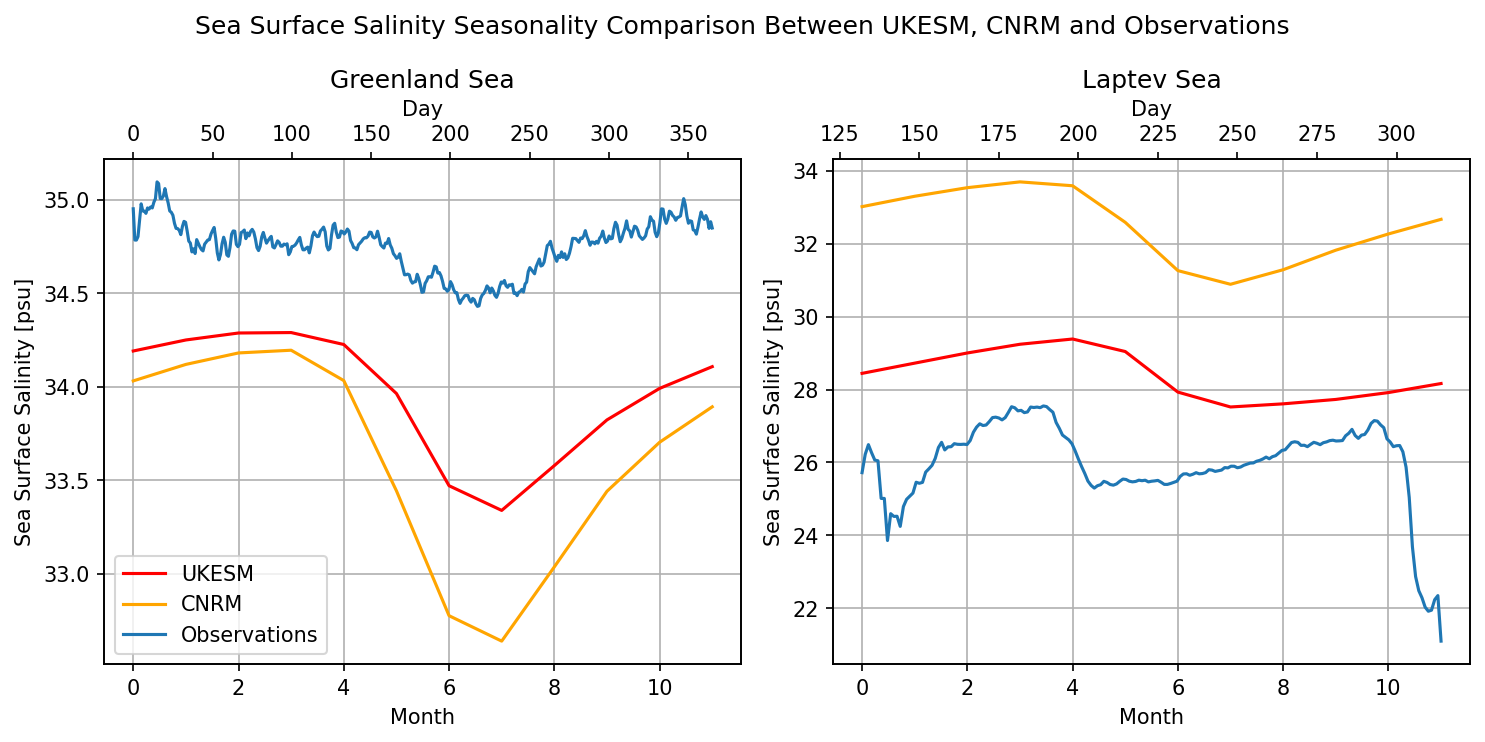

In [103]:
fig, ax = plt.subplots(1,2, figsize=(10,5), dpi=150)
x = np.arange(12)
y = np.arange(len(SatMean))

ln = ax[0].plot(x, MonthlyMean, color='red', label='UKESM')
ln2 = ax[0].plot(x, MonthlyMean3, color='orange', label='CNRM')

ax[1].plot(x, MonthlyMean2, color='red', label='UKESM')
ax[1].plot(x, MonthlyMean4, color='orange', label='CNRM')

ax1 = ax[0].twiny()
ax2 = ax[1].twiny()

ln3 = ax1.plot(y, SatMean, label='Observations')
ax2.plot(y, SatMean2)
ax1.set_xlabel('Day')
ax2.set_xlabel('Day')

for i in range(2):
    ax[i].set_xlabel('Month')
    ax[i].set_ylabel('Sea Surface Salinity [psu]')
    ax[i].grid()

lns = ln + ln2 + ln3
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc='lower left')
plt.suptitle('Sea Surface Salinity Seasonality Comparison Between UKESM, CNRM and Observations')
ax[0].set_title('Greenland Sea')
ax[1].set_title('Laptev Sea')

plt.tight_layout()

*Figure 7: Sesonality of sea surface salinity comparison between UKESM (red), CNRM (orange) and satellite observations (blue). Greenland Sea to the left and Laptev Sea to the right.*

*Fix that laptev sea plot*

Figure 7 shows the seasonal variation of SSS from satellite observations (blue), and multimember averages for the two selected earth system models, UKESM (red) and CNRM (orange). The left panel shows the seasonal SSS at the Greenland Sea, while the right panel shows the seasonal SSS at the Laptev Sea. Here, the SSS for the two models has been calculated by taking the average over the whole model time, 1850-2014, whereas the satellite observations are still only availbale for the years 2009-2019. So there are more years included in the modelled SSS seasonality, and the satellite observations also cover later years. Therefore, comparing these outputs is not completely fair, however, the averages over the years should still give some indication of how well the models perform. 

By first looking at the left panel in figure 7, we see that the models underestimate SSS by around 1 psu in January, with CNRM underestimating slightly more than UKESM. As we approach the months of February-April, this underestimation gets smaller, however, when we move to the months of June-September, where we know that SIE decays, giving a freshwater input into the ocean surface, we see that this difference between the model outputs and the observed values grows. At SSS minimum, which, for the models happens around July, CNRM underestimates the SSS by around 2 psu, while UKESM underestimates by around 1 psu. 

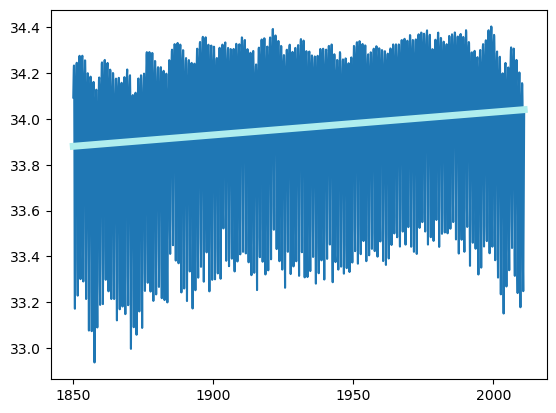

In [16]:
plt.plot(MReg.time, MReg)
x = np.arange(len(MReg.time))
res = stats.linregress(x, MReg)
plt.plot(MReg.time, res.intercept + res.slope*x, color='paleturquoise', lw=5)

## Validation of the Vertical Structure of Model Data

In [ ]:
_id = '3901591'
argo_path = f's3://escience2022/Ada/ARGO/coriolis/{_id}/{_id}_prof.nc'
Argo1 = xr.open_dataset(s3.open(argo_path))

In [ ]:
UKESM = MDS_all.so.mean('member_id', keep_attrs=True)
CNRM = MDS2_all.so.mean('member_id', keep_attrs=True)

In [ ]:
UKESM = UKESM.sel(time=slice('2000', '2010'))
CNRM = CNRM.sel(time=slice('2000', '2010'))

In [ ]:
UKESM = UKESM.where(
    (UKESM['longitude'] < 0)
    & (UKESM['longitude'] > -10)
    & (UKESM['latitude'] < 75)
    & (UKESM['latitude'] > 72),
    drop=True)
CNRM = CNRM.where(
    (CNRM['lon'] < 0)
    & (CNRM['lon'] > -10)
    & (CNRM['lat'] < 75)
    & (CNRM['lat'] > 72),
    drop=True)
MeanUKESM = UKESM.isel(lev=slice(0,60)).mean(dim=['i', 'j', 'time']).compute()
MeanCNRM = CNRM.isel(lev=slice(0,60)).mean(dim=['x', 'y', 'time']).compute()

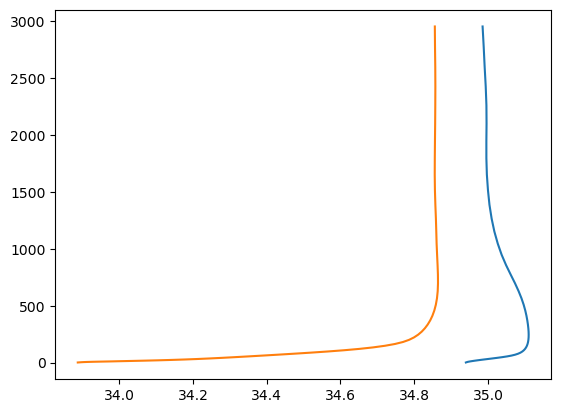

In [122]:
MeanUKESM = UKESM.isel(lev=slice(0,60)).mean(dim=['i', 'j', 'time'])
MeanCNRM = CNRM.isel(lev=slice(0,60)).mean(dim=['x', 'y', 'time'])
plt.plot(MeanUKESM, MeanUKESM.lev)
plt.plot(MeanCNRM, MeanCNRM.lev)

In [ ]:
MDS
Vertical=MDS.sel(time=slice('2000', '2010')).sel(bnds=1).sel(vertices=0).squeeze()
#print(Vertical)
#Vertical = Vertical.sel(longitude=-3, method='nearest')
#Vertical = f.ConvertModelGrid(Vertical)
Vertical = Vertical.where(
    (Vertical['longitude'] < 0)
    & (Vertical['longitude'] > -10)
    & (Vertical['latitude'] < 75)
    & (Vertical['latitude'] > 72),
    drop=True)

f.PlotModel(Vertical.sel(lev=0, method='nearest').isel(time=0), extent=[-16,1,69,77])
#Mean vertical structure over an area

In [ ]:
Vertical2 = Vertical.isel(lev=slice(0,60))
mean_structure=Vertical2['so'].mean('i').mean('j').mean('time')
std_structure=Vertical2['so'].std('i').std('j').mean('time')
fig, ax = plt.subplots()
ax.fill_between(Vertical2.lev, mean_structure-std_structure, mean_structure+std_structure)
plt.plot(mean_structure, Vertical2['lev'])
#plt.plot(mean_structure-std_structure, Vertical2['lev'], color='orange')
#plt.plot(mean_structure+std_structure, Vertical2['lev'], color='orange')
ax.invert_yaxis()
for i in range(len(Argo1['PSAL_ADJUSTED'])):
    plt.plot(Argo1['PSAL_ADJUSTED'][i], Argo1['PRES'][i])

In [ ]:
Argo1.JULD
profiles = Argo1.PSAL_ADJUSTED
depth = Argo1.PRES
profiles=profiles.mean('N_PROF')
fig, ax = plt.subplots()
plt.plot(profiles, np.arange(len(profiles)))
ax.invert_yaxis()

In [ ]:
Vertical2 = Vertical.isel(lev=slice(10,60))
mean_structure=Vertical2['so'].mean('i').mean('j').mean('time')
std_structure=Vertical2['so'].std('i').std('j').mean('time')
fig, ax = plt.subplots()
plt.plot(mean_structure, Vertical2['lev'])
plt.plot(mean_structure-std_structure, Vertical2['lev'], color='orange')
plt.plot(mean_structure+std_structure, Vertical2['lev'], color='orange')
ax.invert_yaxis()
for i in range(len(Argo1['PSAL_ADJUSTED'])):
    plt.plot(Argo1['PSAL_ADJUSTED'][i][10:], Argo1['PRES'][i][10:])